# Overview of the cointegration strategy

- Background: we learn from stationarity test that btc and etc's price could be non-stationary series.
- Thesis: Cointegration tests identify scenarios where two or more non-stationary time series are integrated together in a way that they cannot deviate from equilibrium in the long term. 
- Test(augmented Engle-Granger two-step cointegration test): Construct the t-statistic of **unit-root** test on residuals($\hat{u}_{t}$).
- Strategy: cointegration between correlated assets gives regression trading opportunity, because of $u_t$ always trends to zero.

$$y_{t}-\beta x_{t}=u_{t}$$

- Notes: strategy valid for long-term holder.

## Preprocess and Cointegration test

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

data_folder = "./data/"
!ls $data_folder
crypto_df = pd.read_csv(data_folder + 'train.csv')
asset_details = pd.read_csv(data_folder + 'asset_details.csv')

asset_details.csv             gresearch_crypto
example_sample_submission.csv supplemental_train.csv
example_test.csv              train.csv


### Correlation preview
- correlation of log-returns

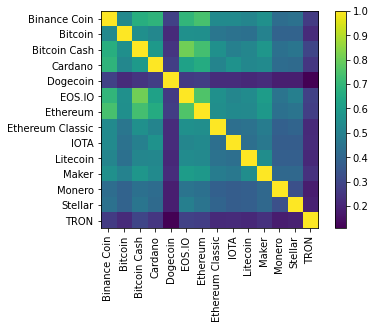

In [2]:
from script.morestats import d2s, log_return
# create dataframe with returns for all assets
all_assets_2021 = pd.DataFrame([])
for asset_id, asset_name in zip(asset_details.Asset_ID, asset_details.Asset_Name):
  asset = crypto_df[crypto_df["Asset_ID"]==asset_id].set_index("timestamp")
  asset = asset.loc[d2s('2021-01-01'):d2s('2021-05-01')]
  asset = asset.reindex(range(asset.index[0],asset.index[-1]+60,60),method='pad')
  lret = log_return(asset.Close.fillna(0))[1:]
  all_assets_2021 = all_assets_2021.join(lret, rsuffix=asset_name, how="outer")
#check the correlation between all assets visualizing the correlation matrix
corr_mat=all_assets_2021.corr()
plt.imshow(corr_mat);
plt.yticks(asset_details.Asset_ID.values, asset_details.Asset_Name.values);
plt.xticks(asset_details.Asset_ID.values, asset_details.Asset_Name.values, rotation='vertical');
plt.colorbar();

In [3]:
corr_mat

,Close,CloseBinance Coin,CloseBitcoin,CloseEOS.IO,CloseEthereum Classic,CloseEthereum,CloseLitecoin,CloseMonero,CloseTRON,CloseStellar,CloseCardano,CloseIOTA,CloseMaker,CloseDogecoin
Close,1.000000,0.528513,0.668473,0.687292,0.280598,0.694192,0.739267,0.536258,0.533499,0.514027,0.554568,0.428793,0.441824,0.264585
CloseBinance Coin,0.528513,1.000000,0.552540,0.520371,0.217747,0.554997,0.551200,0.459980,0.443764,0.436678,0.503134,0.394047,0.391951,0.218535
CloseBitcoin,0.668473,0.552540,1.000000,0.590442,0.245013,0.808453,0.732671,0.555412,0.498286,0.518067,0.577514,0.438740,0.455488,0.295158
CloseEOS.IO,0.687292,0.520371,0.590442,1.000000,0.272907,0.619392,0.655534,0.510268,0.561598,0.519673,0.536764,0.422059,0.415221,0.248991
CloseEthereum Classic,0.280598,0.217747,0.245013,0.272907,1.000000,0.261281,0.271773,0.220834,0.222646,0.210068,0.221756,0.182778,0.184461,0.108558
CloseEthereum,0.694192,0.554997,0.808453,0.619392,0.261281,1.000000,0.754622,0.556721,0.517398,0.537107,0.601995,0.452300,0.493224,0.282653
CloseLitecoin,0.739267,0.551200,0.732671,0.655534,0.271773,0.754622,1.000000,0.548243,0.531927,0.526872,0.584842,0.437780,0.452625,0.273995
CloseMonero,0.536258,0.459980,0.555412,0.510268,0.220834,0.556721,0.548243,1.000000,0.433188,0.443433,0.483706,0.381819,0.396913,0.214289
CloseTRON,0.533499,0.443764,0.498286,0.561598,0.222646,0.517398,0.531927,0.433188,1.000000,0.433138,0.464661,0.372338,0.371139,0.217061
CloseStellar,0.514027,0.436678,0.518067,0.519673,0.210068,0.537107,0.526872,0.443433,0.433138,1.000000,0.545626,0.379831,0.378845,0.211113


## Cointegration test

- reference: [https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.coint.html](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.coint.html)
- `coint()`: Augmented Engle-Granger two-step cointegration test. The null hypothesis is no cointegration. Returns `(t-statistic, p-value, crit_value[1%, 5 %,10 %])`

In [4]:
import statsmodels.tsa.stattools as ts
btc = all_assets_2021['CloseBitcoin']
etc = all_assets_2021['CloseEthereum']
coin_result = ts.coint(btc, etc) 

In [5]:
coin_result

(-64.04918144357, 0.0, array([-3.8965034 , -3.33616537, -3.04447455]))

The null hypothesis is no cointegration. Given p-value almost zero here, we reject the null and state that there is cointegration relationship between BTC and ETC as we expected. Next, get the cointegration parameter $\hat{\beta}$ from the regression equation above to help build the trading strategy.

In [6]:
import statsmodels.api as sm
est=sm.OLS(btc, etc)
est = est.fit()
beta = est.params['CloseEthereum']
beta

0.6595785281521052

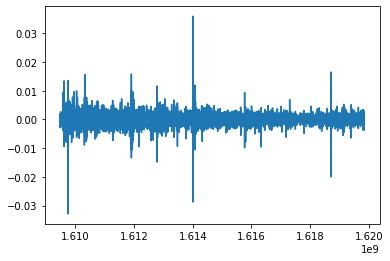

In [7]:
resids=btc- beta*etc
volatility = resids.std()
plt.plot(resids)
plt.show()

## Trading signals

It means $BTC - \beta* ETC$ is stationary over long-term, and giving us the trading strategy that,
- Build up a pool: 1 unit long position of BTC, $\beta$ unit of short position of ETC.
- When the value of the pool is positive high, we should sell(short) the pool.
- When the value of the pool is negative low, we should buy(long) the pool.
- The deviation measure(volatility $\sigma$) of the resids gives the threshold for selling/buying signals.
- When the value of the pool got back to within the safe $\sigma$ range, we clear the position.

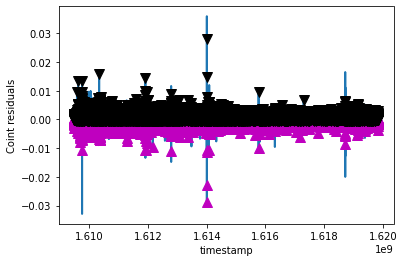

In [8]:
from script.strategy import coint_strategy
signals = coint_strategy(coin_resid= resids, threshold=[0.5,1], plot_signal=True)

## Backtesting

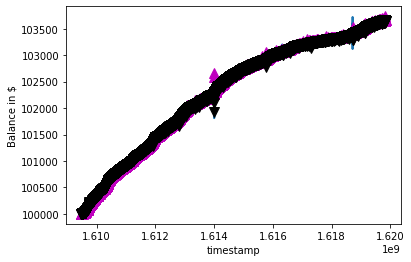

In [9]:
from script.backtest import bt
result = bt(asset_df=resids, signals=signals, strategy='coint',
                initial_capital = float(100000.0), shares_signal=100, plot_balance=True)

In [10]:
result

,Shares,holdings,cash,balance,returns
timestamp,,,,,
1609477260,0.0,0.000000,100000.000000,100000.000000,NaN
1609477320,0.0,0.000000,100000.000000,100000.000000,0.000000
1609477380,0.0,0.000000,100000.000000,100000.000000,0.000000
1609477440,0.0,0.000000,100000.000000,100000.000000,0.000000
1609477500,0.0,0.000000,100000.000000,100000.000000,0.000000
...,...,...,...,...,...
1619841360,-18500.0,-8.534620,103665.994785,103657.460165,-0.000062
1619841420,-18500.0,0.596386,103665.994785,103666.591171,0.000088
1619841480,-18500.0,-10.739790,103665.994785,103655.254995,-0.000109
